<a href="https://colab.research.google.com/github/Viliuskerutis/AML/blob/main/AML_MP3_Kerutis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project 3: Viral prediction

Date: 2020.12.14

Author: © 2020 [Vilius Kerutis](https://www.google.com/search?q=Vilius+Kerutis&oq=Vilius+Kerutis)  
Template author: © 2020 [Mantas Lukoševičius](https://mantas.info/)

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

You should only eddit this notebook where it is allowed, comment on all of your improvements in markdown cells and in your presentation.

Here we analyze open COVID-19 data from https://ourworldindata.org/coronavirus.

## Load the data

In [28]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

Download the data to cache locally. Do this once (a day), and comment out again, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [29]:
#'''
import requests
fname = 'owid-covid-data.csv'
url = 'https://covid.ourworldindata.org/data/' + fname
r = requests.get(url)
open(fname, 'wb').write(r.content)
#''';

14708341

Load the file to Pandas.

In [30]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

The time series to predict.

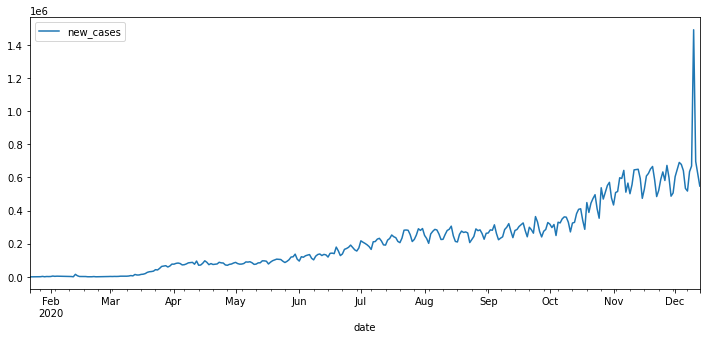

In [31]:
column = 'new_cases'
time_series = df[df.iso_code=='OWID_WRL'][['date',column]].set_index('date')
time_series.plot(figsize=(12,5),logy=False)

Error measure used to evaluate your solution is Root Mean Square Log Error (RMSLE), square-root of 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error.

In [32]:
from sklearn.metrics import mean_squared_log_error
def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

Split the data into training and testing. You can temporality fix the dates in your experiments.

In [33]:
from datetime import timedelta
# last_date will be 2020-12-23 in final testing, and other dates set accordingly 
last_semester_date = pd.Timestamp('2020-12-13') # buvo 23
last_date = time_series.index[-1]
if last_date >= last_semester_date:
    last_date = last_semester_date #  # 
    print("We can test now!")
# will be 2020-12-16 - the last date available before your dedline: end of 2020-12-17
last_training_date = last_date - timedelta(days=7) 
first_prediction_date = last_date - timedelta(days=6)
last_prediction_date = last_date
(last_training_date, first_prediction_date, last_prediction_date)

We can test now!


(Timestamp('2020-12-06 00:00:00'),
 Timestamp('2020-12-07 00:00:00'),
 Timestamp('2020-12-13 00:00:00'))

In [19]:
training_time_series = time_series[:last_training_date]
testing_time_series = time_series[first_prediction_date:last_prediction_date]

# My models

**This is the only section which you should rewrite and expand significanlty providing/documenting your models tried and results with them. **

Give links to the sources of the models and the ideas!

Execution of this section should not take long (no training here ;).

## A simple persistency model 

Returns the last week as the prediction for the next one. 

Validation MRSLE with last_date=2020-12-07 is 0.07974867401899698. Training time: negligible. No hyper parameter optimization tried.

In [34]:
def get_last_week(train_data):
    return train_data[-7:]

## Standard Facebook Prophet prediction library

Taken from https://facebook.github.io/prophet/.

Validation MRSLE with last_date=2020-12-07 is 0.11099341341289806. Training time: 1.55 ms on Colab . No hyper parameter optimization tried.

In [35]:
# Install a pip package in the current Jupyter kernel if it's not present (takes some time). It is
# It is present in Colab.
# from https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
# import sys
# !{sys.executable} -m pip install pystan
# !{sys.executable} -m pip install fbprophet
from fbprophet import Prophet
def use_fb_prophet(train_data):
    m = Prophet()
    # the data must have the specific columns
    a = train_data.reset_index()
    b = a.rename(columns={'date': 'ds', 'new_cases': 'y'})

    m.fit(b)
    prediction_dates = m.make_future_dataframe(periods=7, include_history=False) 
    prediction = m.predict(prediction_dates)
    # and be formated back
    return prediction.set_index('ds')['yhat']

## Another model

Validation types, variations and hyper parameters tried (last_date=2020-12-07):

The results can be presented in Tables like this:

| Variation or hyper-parameter values | (Cross?-)Validation accuracy |
|-------|------------------------------|
| Variation 1 |    0.800000000000                 |

More on formatting markdown: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet


...

## My main best model

Was selected to be ...


In [36]:
def my_best_method(train_data):
    model = LinearRegression()
    model.fit(train_data, train_data)
    pred = model.predict(train_data)
    return get_last_week(pred)

# Testing / validation

Do not edit beyound this point!

Run the training and prediction with your best model:

In [37]:
import time
start_time = time.time()

predicted_time_series = my_best_method(training_time_series)

end_time = time.time()
elapsed_time = end_time - start_time
max_training_time = 3*60*1000
print('Predicting time: %.2f ms (max %i ms.)' %(elapsed_time,max_training_time))  
assert elapsed_time <= max_training_time, 'Training is too long!'

Predicting time: 0.01 ms (max 180000 ms.)


In [24]:
predicted_time_series

,new_cases
date,
2020-11-30,505910.0
2020-12-01,604959.0
2020-12-02,646584.0
2020-12-03,690367.0
2020-12-04,678344.0
2020-12-05,640731.0
2020-12-06,533695.0


Compute the error of your best model:

In [38]:
RMSLE(testing_time_series, predicted_time_series)

0.29244235072945596

In [43]:
predicted_time_series

array([[505910.],
       [604959.],
       [646584.],
       [690367.],
       [678344.],
       [640731.],
       [533695.]])

## Information on the obtained hardware

Only relavant if execution time is in question: then it is tested on Colab T100 node, just as in MP2.

In [39]:
import os
osname = os.name
print(osname)
if osname == 'posix':
    f = os.popen('nvidia-smi')
    print(f.read())

    f = os.popen('lscpu')
    print(f.read())
elif osname == 'nt':
    # from https://winaero.com/get-cpu-information-via-command-prompt-in-windows-10/
    f = os.popen('wmic cpu get caption, deviceid, name, numberofcores, maxclockspeed, status')
    print(f.read())

posix
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.


Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           AuthenticAMD
CPU family:          23
Model:               49
Model name:          AMD EPYC 7B12
Stepping:            0
CPU MHz:             2249.998
BogoMIPS:            4499.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            16384K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid extd_api

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
